In [1]:
import matplotlib.pyplot as plt
import torch
import gpytorch
import time
import numpy as np

%matplotlib inline

In [2]:
import pickle

In [3]:
import finite_ntk
%pdb

Automatic pdb calling has been turned ON


In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    # exact RBF Gaussian process class
    def __init__(self, train_x, train_y, likelihood, model, use_linearstrategy=False):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = finite_ntk.lazy.NTK(
            model=model, use_linearstrategy=use_linearstrategy
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
model = torch.nn.Sequential(
    torch.nn.Linear(5, 200),
    torch.nn.ELU(),
    torch.nn.Linear(200, 2000),
    torch.nn.ELU(),
    torch.nn.Linear(2000, 200),
    torch.nn.ELU(),
    torch.nn.Linear(200, 1),
).cuda()

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()

gpmodel = ExactGPModel(torch.randn(10, 5).cuda(), torch.randn(10).cuda(), likelihood, model).cuda()
parspace_gpmodel = ExactGPModel(torch.randn(10, 5).cuda(), torch.randn(10).cuda(), 
                                likelihood, model, use_linearstrategy=True).cuda()

In [7]:
def run_model_list(mm, n_list):
    num_data_list = []
    for n in num_data_points:
        mm.train()
        #parspace_gpmodel.train()

        print('N: ', n)

        data = torch.randn(n, 5).cuda()
        y = torch.randn(n).cuda()

        mm.set_train_data(data, y, strict=False)
        #parspace_gpmodel.set_train_data(data, y, strict=False)

        start = time.time()
        logprob = likelihood(mm(data)).log_prob(y)
        log_end = time.time() - start

        #start = time.time()
        #logprob = likelihood(parspace_gpmodel(data)).log_prob(y)
        #plog_end = time.time() - start

        mm.eval()
        #parspace_gpmodel.eval()

        with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_eager_kernel_size(200):
            test_data = torch.randn(50, 5).cuda()

            start = time.time()
            pred_vars = mm(test_data).mean
            var_end = time.time() - start

    #         start = time.time()
    #         pred_vars = parspace_gpmodel(data).variance
    #         pvar_end = time.time() - start

        #timings = [log_end, plog_end, var_end, pvar_end]
        #timings = [log_end, plog_end]
        #print(timings)
        num_data_list.append([log_end, var_end])
    
        mm.prediction_strategy = None
    
    return num_data_list

In [8]:
num_data_points = [300, 500, 1000, 5000, 10000, 25000, 50000, 100000]

fun_space_list = run_model_list(gpmodel, num_data_points)
del gpmodel



N:  300
N:  500
N:  1000
N:  5000
N:  10000


/home/wesley/Documents/Code/wjm_gpytorch/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 0.02696886658668518 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


N:  25000


/home/wesley/Documents/Code/wjm_gpytorch/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 0.06581071764230728 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


N:  50000


/home/wesley/Documents/Code/wjm_gpytorch/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 0.9565521478652954 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


N:  100000


/home/wesley/Documents/Code/wjm_gpytorch/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 0.05929410457611084 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


In [9]:
par_space_list = run_model_list(parspace_gpmodel, num_data_points)
del parspace_gpmodel

N:  300
torch.Size([803601])
N:  500
torch.Size([803601])
N:  1000
torch.Size([803601])
N:  5000
torch.Size([803601])
N:  10000
torch.Size([803601])
N:  25000
torch.Size([803601])
N:  50000
torch.Size([803601])
N:  100000
torch.Size([803601])


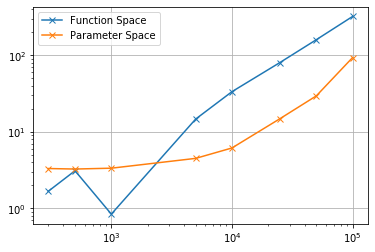

In [10]:
plt.plot(num_data_points, np.stack(fun_space_list)[:,1], marker = 'x', label = 'Function Space')
plt.plot(num_data_points, np.stack(par_space_list)[:,1], marker = 'x', label = 'Parameter Space')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()

In [11]:
numpars = 0
for p in model.parameters():
    numpars += p.numel()
print(numpars)

803601


In [13]:
with open('../data/ntk_mlp_varying_data_speed_gp.pkl', 'wb') as handle:
    plot_dict = {
        'N': num_data_points,
        'ntk': fun_space_list,
        'fisher': par_space_list,
        'numpars': numpars
    }
    pickle.dump(plot_dict, handle, pickle.HIGHEST_PROTOCOL)